# Market Basket Anlysis pada Data Online Retail

## 1. Import libraries dan dataset

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime as dt
import time
from memory_profiler import memory_usage

# Parameter Konfigurasi Runtime untuk Matplotlib
plt.rcParams['font.family'] = 'Verdana'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Apriori Algorithm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Fp-growth Algorithm
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
# Read data
df = pd.read_csv('CleanOnlineRetail.csv', encoding = 'unicode_escape')
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_2368\956812423.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CleanOnlineRetail.csv', encoding = 'unicode_escape')


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,19.5
1,1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
2,2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
3,3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
4,4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,12.5


In [3]:
# List of all countries
country_list = list(dict(df['Country'].value_counts()).keys())
print('List of all countries:', country_list)

List of all countries: ['United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Netherlands', 'Switzerland', 'Belgium', 'Portugal', 'Australia', 'Norway', 'Channel Islands', 'Italy', 'Finland', 'Cyprus', 'Sweden', 'Austria', 'Denmark', 'Poland', 'Israel', 'Hong Kong', 'Japan', 'Singapore', 'USA', 'Iceland', 'Canada', 'Greece', 'Malta', 'United Arab Emirates', 'European Community', 'RSA', 'Lebanon', 'Brazil', 'Czech Republic', 'Bahrain', 'Saudi Arabia']


In [4]:
# Function yang memfilter data berdasarkan nama negara
def choose_country(country = "all", data = df):
    if country == "all":
        return data
    else:
        temp_df = data[data["Country"] == country]
        temp_df.reset_index(drop= True, inplace= True)
        return temp_df

## 2. United Kingdom data

 Sebagian besar transaksi berasal dari United Kingdom sehingga kami membatasi data yang akan kami gunakan hanya untuk transaksi yang berasal dari United Kingdom

In [5]:
uk_retail = choose_country("United Kingdom")
uk_retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,19.5
1,1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
2,2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
3,3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
4,4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,12.5


### 2.1 Membuat data basket (keranjang)

- Kami sekarang membuat data basket (keranjang) yang akan berisi Kuantitas setiap item yang dibeli per transaksi (InvoiceNo)
- Kerangka data ini pada dasarnya adalah 'keranjang' yang 'dibawa' oleh pelanggan ke kasir di toko
- Ini menunjukkan kepada kita berapa banyak pelanggan/transaksi ini (InvoiceNo) membeli barang tertentu
- Jika angkanya 0, maka pelanggan ini tidak membeli barang tersebut
- Jika menunjukkan nilai lain (misalnya 12), berarti pelanggan telah membeli sebanyak 12 item.

In [6]:
basket_uk = uk_retail.groupby(['InvoiceNo', 'Description']).sum()['Quantity'].unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_uk.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Encode data

- Dalam market basket analysis, jumlah setiap barang yang dibeli tidak terlalu penting
- Yang penting suatu barang dibeli atau tidak, karena kita hanya ingin tahu, apa hubungannya membeli suatu barang dengan membeli barang lainnya.
- Jadi kita mengkodekan data keranjang menjadi data biner yang menunjukkan apakah suatu barang dibeli (1) atau tidak (0)

In [7]:
# Encode
def encoder(x):
    if(x <= 0): return 0
    if(x >= 1): return 1

In [8]:
# Apply to the dataframe
basket_uk_encoded = basket_uk.applymap(encoder)
basket_uk_encoded.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Filter transaksi yang lebih dari 1 item

- Dalam analisis keranjang pasar, kita akan mengungkap hubungan antara 2 atau lebih item yang dibeli berdasarkan data historis

In [9]:
# Kami akan memfilter transaksi yang kurang dari 2 item
basket_uk_encoded_filtered = basket_uk_encoded[ (basket_uk_encoded > 0).sum(axis=1) >= 2] # Columnwise sum of encoding should be >= 2
basket_uk_encoded_filtered.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Menerapkan algoritma

### 3.1 Apriori Algorithm

- Algoritma Apriori hanya digunakan untuk menemukan item yang sering dibeli dalam dataset
- Dalam menerapkan algoritma apriori, kita dapat menentukan frequent data yang kita inginkan dengan memberikan nilai dukungannya
- Disini kita mendefinisikan item yang sering dibeli adalah item yang dibeli sebanyak 2% dari keseluruhan transaksi, artinya kita akan memberikan nilai support sebesar 0,02

In [10]:
import time
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# Mengubah tipe data menjadi boolean
basket_uk_encoded_filtered = basket_uk_encoded_filtered.astype(bool)

start_time_apriori = time.time()

# Menjalankan algoritma Apriori dengan parameter minimum support 0.02 dan low_memory=True
frequent_itemsets = apriori(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True, low_memory=True)

# Membuat Association Rules
rules_apriori = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Urutkan nilai berdasarkan nilai lift
rules_apriori = rules_apriori.sort_values("lift", ascending=False).reset_index(drop=True)

# Menyimpan waktu akhir eksekusi
end_time_apriori = time.time()

# Menghitung total waktu eksekusi algoritma Apriori
apriori_time = end_time_apriori - start_time_apriori


In [11]:
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.031599,0.029497,0.023190,0.733888,24.880265,0.022258,3.646969,0.991126
1,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.029497,0.031599,0.023190,0.786192,24.880265,0.022258,4.529292,0.988979
2,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.027657,0.032519,0.021613,0.781473,24.031469,0.020714,4.427278,0.985648
3,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.032519,0.027657,0.021613,0.664646,24.031469,0.020714,2.899456,0.990601
4,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.045658,0.042898,0.032190,0.705036,16.435004,0.030232,3.244808,0.984085
...,...,...,...,...,...,...,...,...,...,...
311,(PARTY BUNTING),(REGENCY CAKESTAND 3 TIER),0.100775,0.099199,0.022927,0.227510,2.293479,0.012931,1.166101,0.627186
312,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.100775,0.126330,0.023913,0.237288,1.878315,0.011182,1.145478,0.520012
313,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.126330,0.100775,0.023913,0.189288,1.878315,0.011182,1.109179,0.535223
314,(WHITE HANGING HEART T-LIGHT HOLDER),(JUMBO BAG RED RETROSPOT),0.126330,0.118841,0.026278,0.208008,1.750306,0.011265,1.112586,0.490656


### 3.2 FP-Growth Algorithm

-
Algoritma FP-Growth (Frequent Pattern Growth) adalah metode yang digunakan dalam analisis data untuk menemukan itemsets yang sering muncul bersama-sama dalam dataset transaksi, serta untuk menghasilkan aturan asosiasi dari itemsets tersebu
- Disini kita mendefinisikan item yang sering dibeli adalah item yang dibeli sebanyak 2% dari keseluruhan transaksi, artinya kita akan memberikan nilai support sebesar 0,02t

In [45]:
# Mengukur waktu untuk algoritma FP-Growth
import time  # Impor modul time kembali

start_time_fpgrowth = time.time()  # Menyimpan waktu mulai eksekusi

# Menjalankan algoritma FP-Growth dengan parameter minimum support 0.02
frequent_itemsets = fpgrowth(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)  # Menemukan itemsets yang sering dengan minimum support 0.02

# Membuat Association Rules
rules_fpgrowth = association_rules(frequent_itemsets, metric="lift", min_threshold=1)  # Menghasilkan aturan asosiasi dengan lift minimal 1

# Urutkan nilai berdasarkan nilai lift
rules_fpgrowth = rules_fpgrowth.sort_values("lift",ascending=False).reset_index(drop= True)
#rules_fpgrowth = rules_fpgrowth[(rules_fpgrowth['lift'] >= 3) & (rules['antecedents'].apply(lambda x: len(x) >= 2))]  # Menyaring aturan yang memiliki lift >= 3 dan panjang antecedents >= 2

# Menyimpan waktu akhir eksekusi
end_time_fpgrowth = time.time()  # Menyimpan waktu akhir eksekusi

# Menghitung total waktu eksekusi algoritma FP-Growth
fpgrowth_time = end_time_fpgrowth - start_time_fpgrowth  # Menghitung total waktu eksekusi algoritma FP-Growth


In [ ]:
rules_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.029497,0.031599,0.023190,0.786192,24.880265,0.022258,4.529292,0.988979
1,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.031599,0.029497,0.023190,0.733888,24.880265,0.022258,3.646969,0.991126
2,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.027657,0.032519,0.021613,0.781473,24.031469,0.020714,4.427278,0.985648
3,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.032519,0.027657,0.021613,0.664646,24.031469,0.020714,2.899456,0.990601
4,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042898,0.045658,0.032190,0.750383,16.435004,0.030232,3.823224,0.981248
...,...,...,...,...,...,...,...,...,...,...
311,(REGENCY CAKESTAND 3 TIER),(PARTY BUNTING),0.099199,0.100775,0.022927,0.231126,2.293479,0.012931,1.169534,0.626088
312,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.100775,0.126330,0.023913,0.237288,1.878315,0.011182,1.145478,0.520012
313,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.126330,0.100775,0.023913,0.189288,1.878315,0.011182,1.109179,0.535223
314,(JUMBO BAG RED RETROSPOT),(WHITE HANGING HEART T-LIGHT HOLDER),0.118841,0.126330,0.026278,0.221117,1.750306,0.011265,1.121695,0.486486


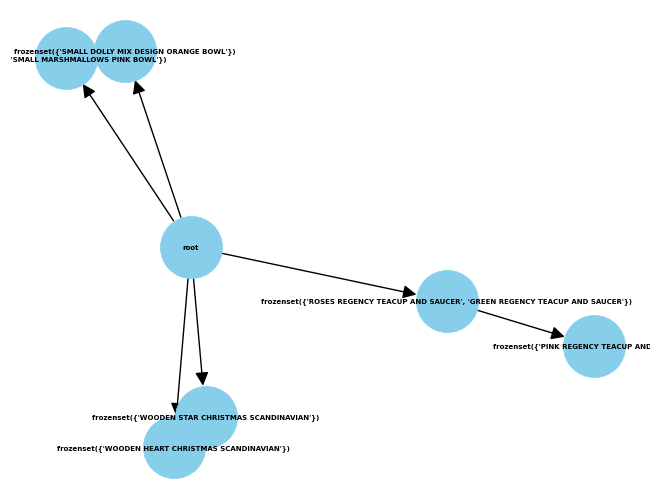

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Fungsi untuk membuat FP-Tree dari aturan yang dihasilkan
def create_fp_tree_from_rules(rules_fpgrowth):
    # Inisialisasi FP-Tree
    fp_tree = nx.DiGraph()
    
    # Membangun FP-Tree dari setiap aturan
    for _, rule in rules_fpgrowth.iterrows():
        antecedent = rule['antecedents']
        consequent = rule['consequents']
        
        # Menambahkan edge dari root ke antecedent
        fp_tree.add_edge('root', antecedent)
        
        # Menambahkan edge dari antecedent ke consequent
        fp_tree.add_edge(antecedent, consequent)

    return fp_tree

# Visualisasi FP-Tree dengan membatasi jumlah aturan yang ditampilkan
def visualize_fp_tree(fp_tree, max_rules_to_display=5):
    # Memilih hanya sebagian aturan yang akan divisualisasikan
    significant_rules = rules_fpgrowth.head(max_rules_to_display)
    
    # Membuat FP-Tree dari aturan yang signifikan
    fp_tree = create_fp_tree_from_rules(significant_rules)
    
    # Visualisasi FP-Tree
    pos = nx.spring_layout(fp_tree, seed=42)  # Layout spring untuk visualisasi
    nx.draw(fp_tree, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=5, font_weight="bold", arrowsize=20)
    plt.show()

# Visualisasi FP-Tree dengan membatasi jumlah aturan yang ditampilkan
visualize_fp_tree(fp_tree, max_rules_to_display=5)



### 3.3 Eclat Algoritm

In [ ]:
import time
import pandas as pd
from itertools import combinations

# Fungsi untuk menghitung support itemset
def hitung_support(itemsets, transaksi):
    itemset_support = {}
    for itemset in itemsets:
        itemset_list = list(itemset)  # Konversi set ke list
        itemset_support[frozenset(itemset)] = transaksi[itemset_list].all(axis=1).sum() / len(transaksi)
    return itemset_support

# Fungsi untuk menghasilkan kombinasi baru dari itemset
def kombinasi_baru(itemsets, panjang):
    return [a.union(b) for a in itemsets for b in itemsets if len(a.union(b)) == panjang]

# Implementasi algoritma Eclat
def eclat(transaksi, min_support=0.02):
    item_tunggal = [{item} for item in transaksi.columns]
    support_dict = hitung_support(item_tunggal, transaksi)
    frequent_itemsets = {itemset: support for itemset, support in support_dict.items() if support >= min_support}
    
    k = 2
    while True:
        kandidat_itemsets = kombinasi_baru(list(frequent_itemsets.keys()), k)
        kandidat_support = hitung_support(kandidat_itemsets, transaksi)
        itemsets_frekuen_sekarang = {itemset: support for itemset, support in kandidat_support.items() if support >= min_support}
        
        if not itemsets_frekuen_sekarang:
            break
        
        frequent_itemsets.update(itemsets_frekuen_sekarang)
        k += 1
        
    frequent_itemsets = [{tuple(itemset): support} for itemset, support in frequent_itemsets.items()]
    return frequent_itemsets

# Fungsi untuk membuat aturan asosiasi dari frequent itemsets
def buat_aturan(frequent_itemsets, transaksi, min_threshold=1):
    aturan = []
    for itemset in frequent_itemsets:
        items = list(itemset.keys())[0]
        support = list(itemset.values())[0]
        for i in range(1, len(items)):
            for antecedent in combinations(items, i):
                consequent = set(items).difference(antecedent)
                antecedent_support = transaksi[list(antecedent)].all(axis=1).sum() / len(transaksi)
                if antecedent_support > 0:
                    confidence = support / antecedent_support
                    if confidence > 0:
                        lift = confidence / (transaksi[list(consequent)].all(axis=1).sum() / len(transaksi))
                        if lift >= min_threshold:
                            aturan.append({
                                'antecedent': antecedent,
                                'consequent': tuple(consequent),
                                'support': support,
                                'confidence': confidence,
                                'lift': lift
                            })
    return pd.DataFrame(aturan)

# Mengubah tipe data menjadi boolean
basket_uk_encoded_filtered = basket_uk_encoded_filtered.astype(bool)

# Mulai pengukuran waktu
start_time_eclat = time.time()

# Menjalankan algoritma Eclat
frequent_itemsets_eclat = eclat(basket_uk_encoded_filtered, min_support=0.02)

# Membuat Aturan Asosiasi dari frequent itemsets
aturan_eclat = buat_aturan(frequent_itemsets_eclat, basket_uk_encoded_filtered, min_threshold=1)

# Urutkan nilai berdasarkan nilai lift
aturan_eclat = aturan_eclat.sort_values("lift", ascending=False).reset_index(drop=True)

# Menyimpan waktu akhir eksekusi
end_time_eclat = time.time()

# Menghitung total waktu eksekusi algoritma Eclat
eclat_time = end_time_eclat - start_time_eclat

In [ ]:
aturan_eclat

,antecedent,consequent,support,confidence,lift
0,"(WOODEN HEART CHRISTMAS SCANDINAVIAN,)","(WOODEN STAR CHRISTMAS SCANDINAVIAN,)",0.023190,0.733888,24.880265
1,"(WOODEN STAR CHRISTMAS SCANDINAVIAN,)","(WOODEN HEART CHRISTMAS SCANDINAVIAN,)",0.023190,0.786192,24.880265
2,"(SMALL MARSHMALLOWS PINK BOWL,)","(SMALL DOLLY MIX DESIGN ORANGE BOWL,)",0.021613,0.781473,24.031469
3,"(SMALL DOLLY MIX DESIGN ORANGE BOWL,)","(SMALL MARSHMALLOWS PINK BOWL,)",0.021613,0.664646,24.031469
4,"(PINK REGENCY TEACUP AND SAUCER,)","(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.032190,0.705036,16.435004
...,...,...,...,...,...
311,"(PARTY BUNTING,)","(REGENCY CAKESTAND 3 TIER,)",0.022927,0.227510,2.293479
312,"(PARTY BUNTING,)","(WHITE HANGING HEART T-LIGHT HOLDER,)",0.023913,0.237288,1.878315
313,"(WHITE HANGING HEART T-LIGHT HOLDER,)","(PARTY BUNTING,)",0.023913,0.189288,1.878315
314,"(JUMBO BAG RED RETROSPOT,)","(WHITE HANGING HEART T-LIGHT HOLDER,)",0.026278,0.221117,1.750306


## 4. Membandingkan Kinerja Apriori dan FP-Growth

Dari Hasil Running Algoritma Apriori dan FP-Growth didapatkan jumlah rules yang sama yaitu 316 rules

In [ ]:
# Displays many generated rules
print(f"Banyak rules yang dihasilkan dengan algoritma apriori: {len(rules_apriori)}")
print(f"Banyak rules yang dihasilkan dengan algoritma fpgrowth: {len(rules_fpgrowth)}")
print(f"Banyak rules yang dihasilkan dengan algoritma fpgrowth: {len(aturan_eclat)}")

Banyak rules yang dihasilkan dengan algoritma apriori: 316
Banyak rules yang dihasilkan dengan algoritma fpgrowth: 316
Banyak rules yang dihasilkan dengan algoritma fpgrowth: 316


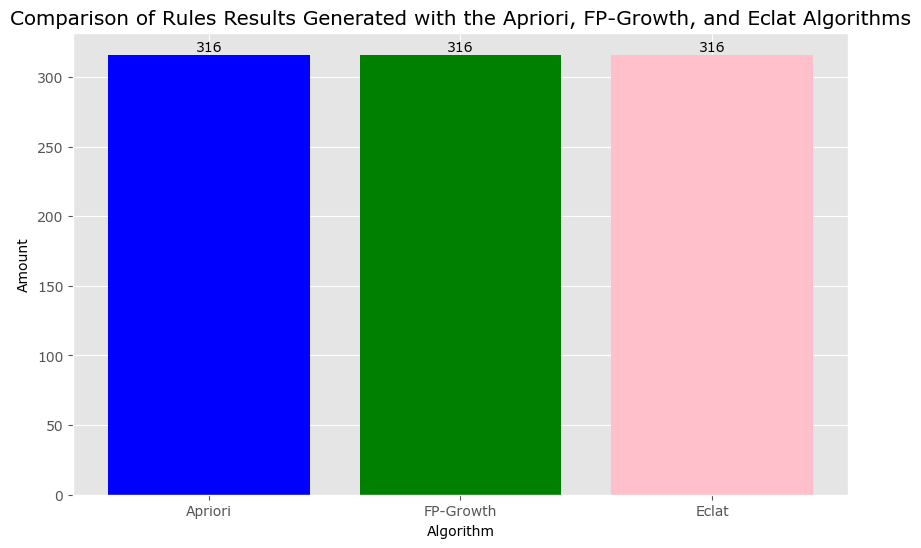

In [ ]:
# Nama algoritma dan waktu komputasi
algorithms = ['Apriori', 'FP-Growth', 'Eclat']
times = [len(rules_apriori), len(rules_fpgrowth), len(aturan_eclat)]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color=['blue', 'green', 'pink'])

# Menambahkan judul dan label
plt.title('Comparison of Rules Results Generated with the Apriori, FP-Growth, and Eclat Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Amount')

# Menambahkan teks pada setiap bar
for i, amount in enumerate(times):
    plt.text(i, amount + 0.01, f'{amount}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [ ]:
# Display the computation times
print(f"Apriori algorithm time: {apriori_time:.4f} seconds")
print(f"FP-Growth algorithm time: {fpgrowth_time:.4f} seconds")
print(f"FP-Growth algorithm time: {eclat_time:.4f} seconds")

Apriori algorithm time: 10.4961 seconds
FP-Growth algorithm time: 4.6203 seconds
FP-Growth algorithm time: 330.1076 seconds


Algoritma FP-Growth lebih cepat daripada Apriori karena menggunakan struktur data FP-Tree yang kompresi untuk menyimpan informasi frekuensi item secara efisien, sehingga menghindari eksplisitnya generasi semua kandidat itemsets yang diperlukan dalam Apriori. FP-Growth hanya memerlukan dua kali pembacaan dataset: sekali untuk membangun FP-Tree dan sekali lagi untuk mengekstrak pola frekuensi tinggi, berbeda dengan Apriori yang harus memindai dataset berulang kali untuk setiap level kombinasi item. Selain itu, FP-Growth mengurangi redundansi data dengan menggabungkan transaksi yang memiliki prefiks yang sama dan menggunakan memori secara lebih efisien, menghindari kebutuhan untuk menyimpan semua kandidat itemsets dalam memori seperti pada Apriori

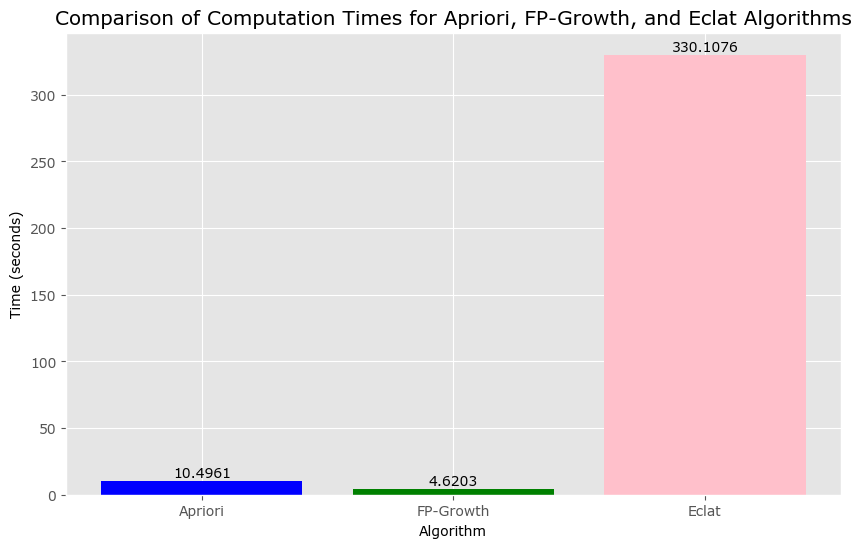

In [ ]:
# Nama algoritma dan waktu komputasi
algorithms = ['Apriori', 'FP-Growth', 'Eclat']
times = [apriori_time, fpgrowth_time, eclat_time]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color=['blue', 'green', 'pink'])

# Menambahkan judul dan label
plt.title('Comparison of Computation Times for Apriori, FP-Growth, and Eclat Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')

# Menambahkan teks pada setiap bar
for i, time in enumerate(times):
    plt.text(i, time + 0.01, f'{time:.4f}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from memory_profiler import memory_usage
from itertools import combinations
from joblib import Parallel, delayed

# Fungsi untuk menghitung support itemset dengan pemrosesan paralel
def hitung_support_parallel(itemsets, transaksi, n_jobs=-1):
    def calc_support(itemset):
        itemset_list = list(itemset)
        return frozenset(itemset), transaksi[itemset_list].all(axis=1).sum() / len(transaksi)
    
    support = Parallel(n_jobs=n_jobs)(delayed(calc_support)(itemset) for itemset in itemsets)
    return dict(support)

# Fungsi untuk menghasilkan kombinasi baru dari itemset
def kombinasi_baru_efisien(itemsets, panjang):
    itemsets = list(itemsets)
    return [itemsets[i].union(itemsets[j]) for i in range(len(itemsets)) for j in range(i+1, len(itemsets)) if len(itemsets[i].union(itemsets[j])) == panjang]

# Implementasi algoritma Eclat dengan optimisasi
def eclat(transaksi, min_support=0.02, max_comb_len=4):
    item_tunggal = [{item} for item in transaksi.columns]
    support_dict = hitung_support_parallel(item_tunggal, transaksi)
    frequent_itemsets = {itemset: support for itemset, support in support_dict.items() if support >= min_support}
    
    k = 2
    while True:
        if k > max_comb_len:
            break
        kandidat_itemsets = kombinasi_baru_efisien(list(frequent_itemsets.keys()), k)
        kandidat_support = hitung_support_parallel(kandidat_itemsets, transaksi)
        itemsets_frekuen_sekarang = {itemset: support for itemset, support in kandidat_support.items() if support >= min_support}
        
        if not itemsets_frekuen_sekarang:
            break
        
        frequent_itemsets.update(itemsets_frekuen_sekarang)
        k += 1
        
    frequent_itemsets = [{tuple(itemset): support} for itemset, support in frequent_itemsets.items()]
    return frequent_itemsets

# Fungsi untuk membuat aturan asosiasi dari frequent itemsets
def buat_aturan(frequent_itemsets, transaksi, min_threshold=1):
    aturan = []
    for itemset in frequent_itemsets:
        items = list(itemset.keys())[0]
        support = list(itemset.values())[0]
        for i in range(1, len(items)):
            for antecedent in combinations(items, i):
                consequent = set(items).difference(antecedent)
                antecedent_support = transaksi[list(antecedent)].all(axis=1).sum() / len(transaksi)
                if antecedent_support > 0:
                    confidence = support / antecedent_support
                    if confidence > 0:
                        lift = confidence / (transaksi[list(consequent)].all(axis=1).sum() / len(transaksi))
                        if lift >= min_threshold:
                            aturan.append({
                                'antecedent': antecedent,
                                'consequent': tuple(consequent),
                                'support': support,
                                'confidence': confidence,
                                'lift': lift
                            })
    return pd.DataFrame(aturan)

# Fungsi untuk menjalankan algoritma Apriori
def run_apriori():
    frequent_itemsets = apriori(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)
    rules_apriori = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules_apriori = rules_apriori.sort_values("lift", ascending=False).reset_index(drop=True)
    return rules_apriori

# Fungsi untuk menjalankan algoritma FP-Growth
def run_fpgrowth():
    frequent_itemsets = fpgrowth(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)
    rules_fpgrowth = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules_fpgrowth = rules_fpgrowth.sort_values("lift", ascending=False).reset_index(drop=True)
    return rules_fpgrowth

# Fungsi untuk menjalankan algoritma Eclat
def run_eclat():
    frequent_itemsets_eclat = eclat(basket_uk_encoded_filtered, min_support=0.02)
    aturan_eclat = buat_aturan(frequent_itemsets_eclat, basket_uk_encoded_filtered, min_threshold=1)
    aturan_eclat = aturan_eclat.sort_values("lift", ascending=False).reset_index(drop=True)
    return aturan_eclat

# Mengubah tipe data menjadi boolean
basket_uk_encoded_filtered = basket_uk_encoded_filtered.astype(bool)

# Menghapus kolom (item) yang memiliki sedikit transaksi
min_item_support = 0.01  # Contoh threshold support item minimum
item_support = basket_uk_encoded_filtered.sum(axis=0) / len(basket_uk_encoded_filtered)
basket_uk_encoded_filtered = basket_uk_encoded_filtered.loc[:, item_support >= min_item_support]

# Mengukur penggunaan memori untuk Apriori
apriori_memory = memory_usage(run_apriori, interval=0.1)
apriori_max_memory = max(apriori_memory)

# Mengukur penggunaan memori untuk FP-Growth
fpgrowth_memory = memory_usage(run_fpgrowth, interval=0.1)
fpgrowth_max_memory = max(fpgrowth_memory)

# Mengukur penggunaan memori untuk Eclat
eclat_memory = memory_usage(run_eclat, interval=0.1)
eclat_max_memory = max(eclat_memory)

# Menampilkan penggunaan memori
print(f"Apriori algorithm max memory usage: {apriori_max_memory:.2f} MiB")
print(f"FP-Growth algorithm max memory usage: {fpgrowth_max_memory:.2f} MiB")
print(f"Eclat algorithm max memory usage: {eclat_max_memory:.2f} MiB")

Apriori algorithm max memory usage: 2213.81 MiB
FP-Growth algorithm max memory usage: 195.52 MiB
Eclat algorithm max memory usage: 217.17 MiB


Algoritma Apriori menggunakan memori lebih besar daripada algoritma FP-Growth karena secara eksplisit menghasilkan dan menyimpan semua kandidat itemsets pada setiap level kombinasi, yang memerlukan banyak memori, terutama untuk dataset besar. Setiap iterasi Apriori menghasilkan kandidat itemsets baru yang harus disimpan dan diverifikasi terhadap dataset, sehingga memori yang dibutuhkan meningkat secara eksponensial dengan bertambahnya jumlah item dan ukuran dataset. Sebaliknya, FP-Growth menggunakan struktur FP-Tree yang kompresi untuk menyimpan frekuensi item dalam bentuk yang lebih efisien, menghindari penyimpanan eksplisit semua kandidat itemsets, dan secara signifikan mengurangi penggunaan memori dengan mengeliminasi redundansi data melalui penggabungan transaksi dengan prefiks yang sama.

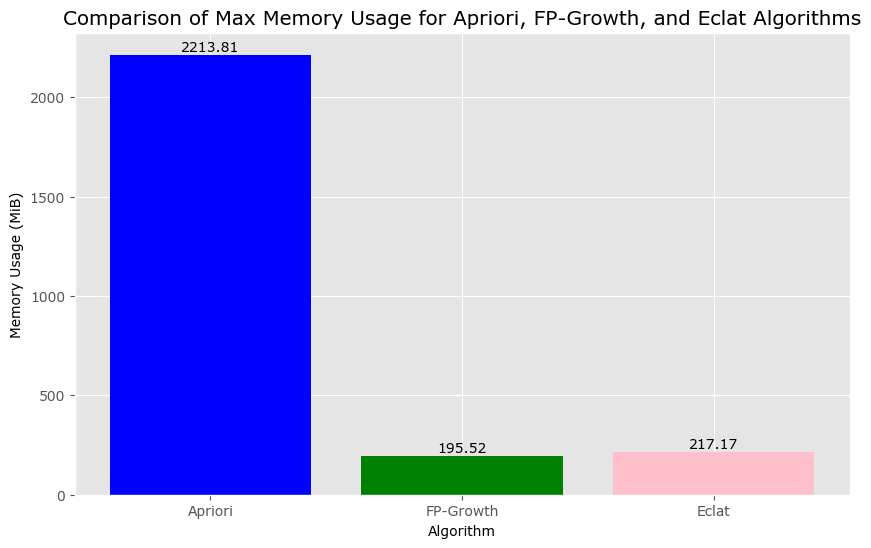

In [46]:
import matplotlib.pyplot as plt

# Nama algoritma dan penggunaan memori maksimum
algorithms = ['Apriori', 'FP-Growth', 'Eclat']
memory_usage = [apriori_max_memory, fpgrowth_max_memory, eclat_max_memory]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, memory_usage, color=['blue', 'green', 'pink'])

# Menambahkan judul dan label
plt.title('Comparison of Max Memory Usage for Apriori, FP-Growth, and Eclat Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Memory Usage (MiB)')

# Menambahkan teks pada setiap bar
for i, memory in enumerate(memory_usage):
    plt.text(i, memory + 0.5, f'{memory:.2f}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

## 5. Product Recommendation based on Association Rules

- Bagian rekomendasi produk dari proyek ini akan menggunakan Association Rules yang ditemukan di bagian Market Basket Analysis
- Rekomendasi produk pada dasarnya adalah salah satu keunggulan Market Basket Analysis di mana Anda dapat merekomendasikan kepada pelanggan produk yang berada dalam kumpulan item yang sama dengan produk pelanggan saat ini.

In [ ]:
# List of all products
product_catalog = list(uk_retail['Description'].unique())
print(f'Ada {len(product_catalog)} produk unik di pasar UK.')

Ada 3893 produk unik di pasar UK.


In [ ]:
def remove_from_list(y, item_to_search):
    newlist = list()
    for i in y:
        if i not in item_to_search:
            newlist.append(i)
    return newlist

In [ ]:
def search_list(item_to_search, list_to_search=rules_apriori['antecedents']):
    # Fungsi ini mencari item dalam daftar aturan asosiasi dan memberikan rekomendasi berdasarkan item yang memiliki nilai lift tertinggi.
    
    print(item_to_search)
    # Mencetak item yang akan dicari untuk rekomendasi.

    max_lift = 0
    # Inisialisasi variabel untuk menyimpan nilai lift tertinggi yang ditemukan.

    item_to_recommend = ''
    # Inisialisasi variabel untuk menyimpan item rekomendasi.

    for i, item in enumerate(list_to_search):
        # Iterasi melalui setiap item dalam daftar aturan asosiasi.
        
        if set(list(item_to_search)).issubset(set(list(item))):
            # Memeriksa apakah item_to_search adalah subset dari item saat ini.
            
            if rules_apriori['lift'][i] > max_lift:
                # Memeriksa apakah nilai lift dari aturan saat ini lebih besar dari max_lift.
                
                max_lift = rules_apriori['lift'][i]
                # Memperbarui max_lift dengan nilai lift yang lebih tinggi.

                y = list(rules_apriori['antecedents'][i])
                # Mendapatkan daftar antecedents dari aturan saat ini.

                x = remove_from_list(y, item_to_search)
                # Menghapus item_to_search dari daftar antecedents untuk mendapatkan item yang tersisa.

                item_to_recommend = list(rules_apriori['consequents'][i]) + x
                # Menggabungkan consequents dengan item yang tersisa untuk mendapatkan rekomendasi.

    if item_to_recommend == '':
        # Jika tidak ada item yang direkomendasikan.
        
        item_to_recommend = []
        # Menginisialisasi item_to_recommend sebagai daftar kosong.

        print(f"Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: {item_to_recommend}")
        # Mencetak pesan bahwa tidak ada rekomendasi yang tersedia.
    else:
        print(f"Orang-orang juga membeli ini: {item_to_recommend}")
        # Mencetak rekomendasi produk yang ditemukan.
    
    return item_to_search, item_to_recommend
    # Mengembalikan item yang dicari dan item yang direkomendasikan.


In [ ]:
dict_to_store = {}
for i in range(len(product_catalog)):
    key, value = search_list([product_catalog[i]])
    dict_to_store[key[0]] = value

['JUMBO BAG PINK POLKADOT']
Orang-orang juga membeli ini: ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG WOODLAND ANIMALS']
['BLUE POLKADOT WRAP']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['RED RETROSPOT WRAP']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['RECYCLING BAG RETROSPOT']
Orang-orang juga membeli ini: ['DOTCOM POSTAGE']
['RED RETROSPOT SHOPPER BAG']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['JUMBO BAG RED RETROSPOT']
Orang-orang juga membeli ini: ['JUMBO BAG PINK POLKADOT', 'JUMBO BAG WOODLAND ANIMALS']
['RED RETROSPOT CHILDRENS UMBRELLA']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['JAM MAKING SET PRINTED']
Orang-orang juga membeli ini: ['JAM MAKING SET WITH JARS']
['RECIPE BOX RETROSPOT']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['CHILDRENS APRON APPLES DESIGN']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['PEG BAG APPLES DESIGN']
Oops! Tidak ada rekomendasi p

In [ ]:
import json

json_file = json.dumps(dict_to_store)
# open file for writing, "w" 
f = open("item_sets.json","w")
# write json object to file
f.write(json_file)

# close file
f.close()

In [ ]:
# Opening JSON file
with open('item_sets.json') as json_file:
    data = json.load(json_file)

In [ ]:
for a in data['JUMBO BAG PINK POLKADOT']:
    print(a)

JUMBO BAG RED RETROSPOT
JUMBO BAG WOODLAND ANIMALS
